<h1 align="center">Appendix A</h1>
<h2 align="center">SVM Analysis on HARTH Dataset</h2> 
<h3 align="center">Name: Andy Malinsky</h3> 
<h4 align="center">Date: 8/12/2024</h4> 

In [1]:
# Import libraries
import requests
import zipfile
import io
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

np.random.seed(24) # set random seed for reproducibility

## Data Preparation

In [2]:
# Load Data from url into dataframes
zip_file_url = "https://archive.ics.uci.edu/static/public/779/harth.zip"
files = ['S006.csv', 'S008.csv', 'S009.csv', 'S010.csv', 'S012.csv', 'S013.csv',
         'S014.csv', 'S015.csv', 'S016.csv', 'S017.csv', 'S018.csv', 'S019.csv',
         'S020.csv', 'S021.csv', 'S022.csv', 'S023.csv', 'S024.csv', 'S025.csv',
         'S026.csv', 'S027.csv', 'S028.csv', 'S029.csv']
loaded_data = {}

# Function to load individual CSV files into pandas DataFrame
def load_csv(file_name, zip_file):
    with zip_file.open('harth/' + file_name) as csv_file:
        df = pd.read_csv(csv_file)
        loaded_data[file_name] = df
        return df
response = requests.get(zip_file_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    dataframes = [load_csv(file_name, zip_file) for file_name in files]

df = pd.concat(dataframes, ignore_index=True)
df = df[['timestamp','back_x','back_y','back_z','thigh_x','thigh_y','thigh_z','label']]
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


In [3]:
# Map Activity Labels
activity_label = {
    1: '1: Walking',
    2: '2: Running',
    3: '3: Shuffling',
    4: '4: Stairs (Ascending)',
    5: '5: Stairs (Descending)',
    6: '6: Standing',
    7: '7: Sitting',
    8: '8: Lying',
    13: '9: Cycling (Sit)',
    14: '10: Cycling (Stand)',
    130: '11: Cycling (Sit, Inactive)',
    140: '12: Cycling (Stand, Inactive)'
}
df_map = df.copy()
df_map['label'] = df['label'].replace(activity_label)
df_map

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6: Standing
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6: Standing
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6: Standing
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6: Standing
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6: Standing
...,...,...,...,...,...,...,...,...
6461323,2019-01-12 00:59:56.940,-1.012939,-0.110840,-0.218994,-0.970215,-0.313232,0.124268,3: Shuffling
6461324,2019-01-12 00:59:56.960,-0.979492,-0.089355,-0.216553,-0.966553,-0.234619,0.113770,3: Shuffling
6461325,2019-01-12 00:59:56.980,-0.969971,-0.057861,-0.204590,-0.997803,-0.097656,0.065186,3: Shuffling
6461326,2019-01-12 00:59:57.000,-1.001953,-0.029785,-0.234863,-1.000000,-0.145996,0.061523,3: Shuffling


In [4]:
# Function to split into scaled independent and dependent
def split_and_scale_data(df, cal_test=False):
    # Split Features Into Independent and Dependent
    x = df[['back_x','back_y','back_z','thigh_x','thigh_y','thigh_z']]
    y = df[['label']].values.ravel()
    
    # Standardize and Normalize Data
    scaler = StandardScaler().fit(x)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = pd.DataFrame(min_max_scaler.fit_transform(scaler.transform(x)), columns=list(x.columns.tolist()), index=x.index)
    if not cal_test:
        print('Mean:\n', x_scaled.mean())
        print('\nStandard deviation:\n', x_scaled.std())
    x_scaled.head()
    
    return x_scaled, y

x_scaled, y = split_and_scale_data(df_map)

Mean:
 back_x     0.691337
back_y     0.397642
back_z     0.557743
thigh_x    0.462827
thigh_y    0.501229
thigh_z    0.510472
dtype: float64

Standard deviation:
 back_x     0.036689
back_y     0.021406
back_z     0.031761
thigh_x    0.039147
thigh_y    0.024283
thigh_z    0.044867
dtype: float64


## Exploratory Data Analysis

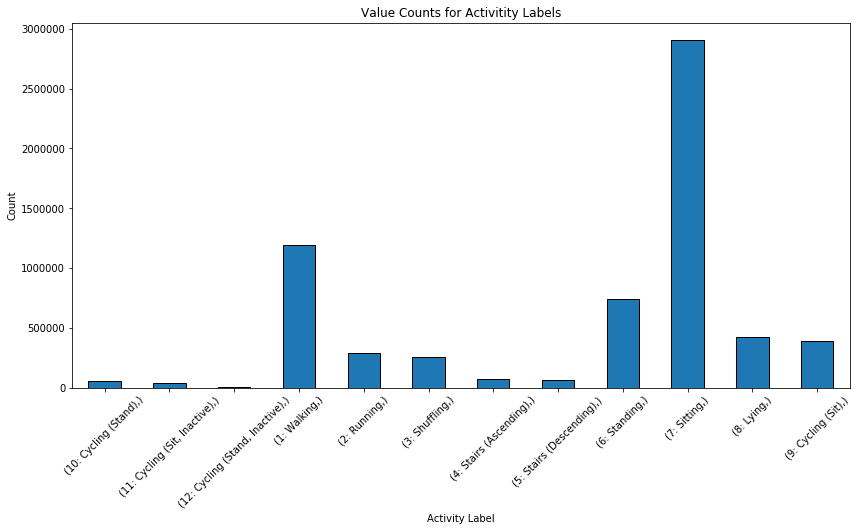

In [5]:
# Histogram of activity label value counts
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
df_map[['label']].value_counts().sort_index().plot(kind='bar', ax=ax, edgecolor='black')
ax.set_xlabel('Activity Label')
ax.set_ylabel('Count')
ax.set_title('Value Counts for Activitity Labels')
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

## SVM Model Training and Analysis

In [6]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=24)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (5169062, 6)
x_test shape: (1292266, 6)
y_train shape: (5169062,)
y_test shape: (1292266,)


In [14]:
# Fit a baseline classifier with default parameters
clf = SGDClassifier(random_state=24, n_jobs=-1)
clf.fit(x_train, y_train) 
y_pred = clf.predict(x_test)
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2)) # Evaluate model performance
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.61
                               precision    recall  f1-score   support

          10: Cycling (Stand)       0.00      0.00      0.00     11171
  11: Cycling (Sit, Inactive)       0.00      0.00      0.00      8314
12: Cycling (Stand, Inactive)       0.00      0.00      0.00      1583
                   1: Walking       0.37      0.57      0.45    239884
                   2: Running       0.02      0.00      0.00     57811
                 3: Shuffling       0.01      0.00      0.00     50976
        4: Stairs (Ascending)       0.00      0.00      0.00     15231
       5: Stairs (Descending)       0.00      0.00      0.00     13446
                  6: Standing       0.19      0.06      0.09    148400
                   7: Sitting       0.76      0.98      0.86    580847
                     8: Lying       0.61      0.83      0.70     85958
             9: Cycling (Sit)       0.40      0.00      0.00     78645

                     accuracy                           0.61

## Hyperparameter Tuning

In [11]:
# Hyperparameter grid search
param_grid = {
    'alpha': [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7], # learning rate
    'loss': ['log', 'hinge', 'modified_huber'], # loss function
    'n_jobs': [-1],
    'random_state': [24]
}
grid = GridSearchCV(SGDClassifier(), param_grid, refit = True, verbose = 3, cv=5, n_jobs=-1) # 5 fold cross validation
grid.fit(x_train, y_train) # fitting the model for grid search 
print(grid.best_params_) # print best parameter after tuning 
print(grid.best_estimator_) # print how our model looks after hyper-parameter tuning 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 28.2min finished


{'alpha': 1e-07, 'loss': 'hinge', 'n_jobs': -1, 'random_state': 24}
SGDClassifier(alpha=1e-07, n_jobs=-1, random_state=24)


In [120]:
# Run model using adjusted hyperparameters
clf_adjusted = SGDClassifier(alpha=1e-7, loss='hinge', random_state=24, n_jobs=-1)
clf_adjusted.fit(x_train, y_train)
y_pred = clf_adjusted.predict(x_test)
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2)) # Evaluate model performance
print(classification_report(y_test, y_pred))

Accuracy: 0.63
                               precision    recall  f1-score   support

          10: Cycling (Stand)       0.00      0.00      0.00     11171
  11: Cycling (Sit, Inactive)       0.00      0.00      0.00      8314
12: Cycling (Stand, Inactive)       0.00      0.00      0.00      1583
                   1: Walking       0.46      0.10      0.16    239884
                   2: Running       0.41      0.02      0.04     57811
                 3: Shuffling       0.00      0.00      0.00     50976
        4: Stairs (Ascending)       0.00      0.00      0.00     15231
       5: Stairs (Descending)       0.00      0.00      0.00     13446
                  6: Standing       0.31      0.97      0.46    148400
                   7: Sitting       0.85      0.98      0.91    580847
                     8: Lying       0.82      0.90      0.85     85958
             9: Cycling (Sit)       0.00      0.00      0.00     78645

                     accuracy                           0.63

In [132]:
# K-Fold Cross Validation on Adjusted Model Parameters
scores = cross_val_score(clf_adjusted, x_scaled, y, cv=5)
print('5-Fold Validation Scores:', scores)
print('5-Fold Validation Min Score:', round(np.min(scores), 2))
print('5-Fold Validation Max Score:', round(np.max(scores), 2))
print('5-Fold Validation Average Score:', round(np.mean(scores), 2))

5-Fold Validation Scores: [0.66901242 0.65515614 0.60574448 0.6582218  0.60452539]
5-Fold Validation Min Score: 0.6
5-Fold Validation Max Score: 0.67
5-Fold Validation Average Score: 0.64


## Metabolic Calorie Counter Experiment

In [110]:
# Hypothetical calorie burn values (calories per minute) based on activity intensity
calorie_burn_rates = {
    1: 4,       # 'Walking'
    2: 10,      # 'Running'
    3: 3,       # 'Shuffling'
    4: 8,       # 'Stairs (Ascending)'
    5: 7,       # 'Stairs (Descending)'
    6: 1.5,     # 'Standing'
    7: 1,       # 'Sitting'
    8: 0.8,     # 'Lying'
    13: 6,      # 'Cycling (Sit)'
    14: 9,      # 'Cycling (Stand)'
    130: 2,     # 'Cycling (Sit, Inactive)'
    140: 2.5    # 'Cycling (Stand, Inactive)'
}
activity_label_inv = {v: k for k, v in activity_label.items()} # inverse label map

# Function to test prediction per person
def predict_calories_burned(dataPath):
    print('\nRunning Test for:', dataPath)
    data = loaded_data[dataPath]
    d_x, d_y = split_and_scale_data(data, True)
    d_pred = list(map(activity_label_inv.get, clf.predict(d_x)))
    cosine_sim = round(cosine_similarity([d_pred], [d_y])[0][0], 2)
    label_variance = round(np.var(d_y), 2)
    print('Cosine similarity Predicted vs Actual:', cosine_sim) # cosine similarity of predicted vs actual labels
    
    # Calculate calories burned on actual vs predicted
    sum_act_cal = 0
    sum_pred_cal = 0
    for i in range(0, len(d_y)):
        sum_act_cal += calorie_burn_rates[d_y[i]]
        sum_pred_cal += calorie_burn_rates[d_pred[i]]
    print('Total Actual Calories Burned:', round(sum_act_cal, 2))
    print('Total Predicted Calories Burned:', round(sum_pred_cal, 2))
    total_error = abs(round(sum_pred_cal - sum_act_cal, 2))
    print('Total Absolute Error (Predicted - Actual):', total_error)
    print('Variance in labels:', label_variance)
    
    return cosine_sim, label_variance, total_error

In [111]:
# Run Calorie Test on All Data Samples
cosine_similarities = []
label_variances = []
total_errors = []

for dataset in loaded_data:
    cosine_sim, label_variance, total_error =  predict_calories_burned(dataset)
    cosine_similarities.append(cosine_sim)
    label_variances.append(label_variance)
    total_errors.append(total_error)


Running Test for: S006.csv
Cosine similarity Predicted vs Actual: 0.45
Total Actual Calories Burned: 717915.8
Total Predicted Calories Burned: 409025.9
Total Absolute Error (Predicted - Actual): 308889.9
Variance in labels: 413.24

Running Test for: S008.csv
Cosine similarity Predicted vs Actual: 0.72
Total Actual Calories Burned: 628091.0
Total Predicted Calories Burned: 419840.8
Total Absolute Error (Predicted - Actual): 208250.2
Variance in labels: 41.55

Running Test for: S009.csv
Cosine similarity Predicted vs Actual: 0.55
Total Actual Calories Burned: 879852.0
Total Predicted Calories Burned: 156227.3
Total Absolute Error (Predicted - Actual): 723624.7
Variance in labels: 887.37

Running Test for: S010.csv
Cosine similarity Predicted vs Actual: 0.79
Total Actual Calories Burned: 1046180.5
Total Predicted Calories Burned: 356767.2
Total Absolute Error (Predicted - Actual): 689413.3
Variance in labels: 6.37

Running Test for: S012.csv
Cosine similarity Predicted vs Actual: 0.97
To

## Scatter Plots of Cosine Similarity vs Label Variance vs Total Absolute Error

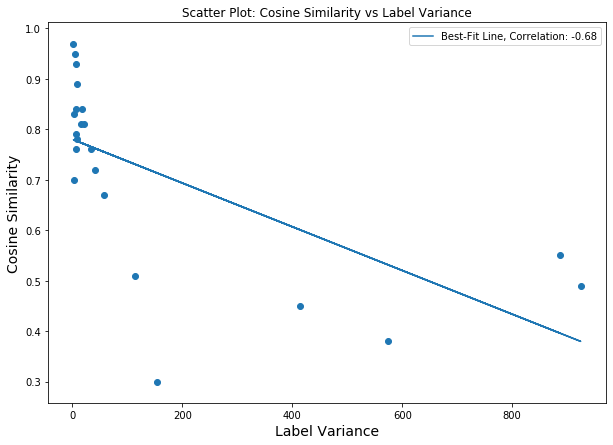

In [112]:
x_plot = np.asarray(label_variances, dtype=np.float32)
y_plot = np.asarray(cosine_similarities, dtype=np.float32)

fig = plt.figure(figsize=(10, 7))
plt.scatter(x_plot, y_plot)
plt.xlabel("Label Variance", size=14)
plt.ylabel("Cosine Similarity", size=14)
plt.title('Scatter Plot: Cosine Similarity vs Label Variance')
a, b = np.polyfit(x_plot, y_plot, 1) # find line of best fit
plt.plot(x_plot, a*(x_plot)+b) # add line of best fit to plot

# calculate correlation using the covariance and standard deviations
correlation = round((np.cov(x_plot,y_plot) / (x_plot.std() * y_plot.std()))[0,1], 2)
plt.legend(['Best-Fit Line, Correlation: '+str(correlation)], loc='upper right')
plt.show()

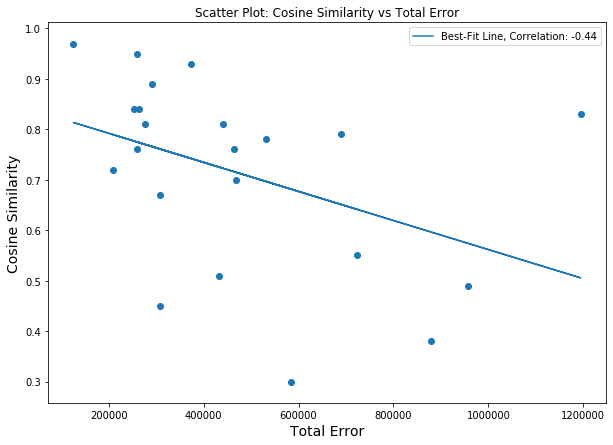

In [113]:
x_plot = np.asarray(total_errors, dtype=np.float32)
y_plot = np.asarray(cosine_similarities, dtype=np.float32)

fig = plt.figure(figsize=(10, 7))
plt.scatter(x_plot, y_plot)
plt.xlabel("Total Error", size=14)
plt.ylabel("Cosine Similarity", size=14)
plt.title('Scatter Plot: Cosine Similarity vs Total Error')
a, b = np.polyfit(x_plot, y_plot, 1) # find line of best fit
plt.plot(x_plot, a*(x_plot)+b) # add line of best fit to plot

# calculate correlation using the covariance and standard deviations
correlation = round((np.cov(x_plot,y_plot) / (x_plot.std() * y_plot.std()))[0,1], 2)
plt.legend(['Best-Fit Line, Correlation: '+str(correlation)], loc='upper right')
plt.show()

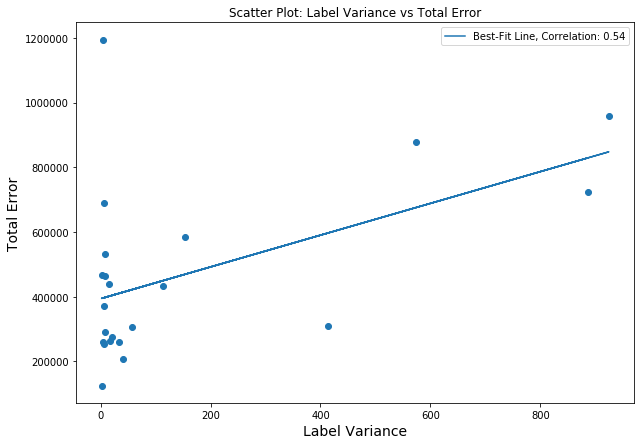

In [114]:
x_plot = np.asarray(label_variances, dtype=np.float32)
y_plot = np.asarray(total_errors, dtype=np.float32)

fig = plt.figure(figsize=(10, 7))
plt.scatter(x_plot, y_plot)
plt.xlabel("Label Variance", size=14)
plt.ylabel("Total Error", size=14)
plt.title('Scatter Plot: Label Variance vs Total Error')
a, b = np.polyfit(x_plot, y_plot, 1) # find line of best fit
plt.plot(x_plot, a*(x_plot)+b) # add line of best fit to plot

# calculate correlation using the covariance and standard deviations
correlation = round((np.cov(x_plot,y_plot) / (x_plot.std() * y_plot.std()))[0,1], 2)
plt.legend(['Best-Fit Line, Correlation: '+str(correlation)], loc='upper right')
plt.show()